# Variationally Inferred Parameterization

Author: [Madhav Kanda](https://madhav-kanda.github.io/)


Occasionally, the Hamiltonian Monte Carlo (HMC) sampler encounters challenges in effectively sampling from the posterior distribution. One illustrative case is [Neal's funnel](https://num.pyro.ai/en/stable/examples/funnel.html). In these situations, the conventional centered parameterization may prove inadequate, leading us to employ non-centered parameterization. However, there are instances where even non-centered parameterization may not suffice, necessitating the utilization of Variationally Inferred Parameterization to attain the desired centeredness within the range of 0 to 1.



The purpose of this tutorial is to implement **Variationally Inferred Parameterization** based on [Automatic Reparameterization of Probabilistic Programs](https://arxiv.org/abs/1906.03028) using **LocScaleReparam** in **Numpyro**.

In [ ]:
%pip -qq install numpyro
%pip -qq install ucimlrepo

In [ ]:
import arviz as az
import numpy as np
from ucimlrepo import fetch_ucirepo

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer.reparam import LocScaleReparam

rng_key = jax.random.PRNGKey(0)

## **1. Dataset**
We will be using the German Credit Dataset for this illustration. The dataset consists of 1000 entries with 20 categorial symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

In [ ]:
def load_german_credit():
    statlog_german_credit_data = fetch_ucirepo(id=144)
    X = statlog_german_credit_data.data.features
    y = statlog_german_credit_data.data.targets
    return X, y

In [ ]:
X, y = load_german_credit()
X

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


Here, X depicts 20 attributes and the values corresponding to these attributes for each person represented in the data entry and y is the output variable corresponding to these attributes

In [ ]:
def data_transform(X, y):
    def categorical_to_int(x):
        d = {u: i for i, u in enumerate(np.unique(x))}
        return np.array([d[i] for i in x])

    categoricals = []
    numericals = []
    numericals.append(np.ones([len(y)]))
    for column in X:
        column = X[column]
        if column.dtype == "O":
            categoricals.append(categorical_to_int(column))
        else:
            numericals.append((column - column.mean()) / column.std())
    numericals = np.array(numericals).T
    status = np.array(y == 1, dtype=np.int32)
    status = np.squeeze(status)

    return jnp.array(numericals), jnp.array(categoricals), jnp.array(status)

Data transformation for feeding it into the Numpyro model

In [ ]:
numericals, categoricals, status = data_transform(X, y)

In [ ]:
x_numeric = numericals.astype(jnp.float32)
x_categorical = [jnp.eye(c.max() + 1)[c] for c in categoricals]
all_x = jnp.concatenate([x_numeric] + x_categorical, axis=1)
num_features = all_x.shape[1]
y = status[jnp.newaxis, Ellipsis]

## **2. Model**
We will be using a logistic regression model with hierarchical prior on coefficient scales

\begin{align}
\log \tau_0 & \sim \mathcal{N}(0,10) & \log \tau_i & \sim \mathcal{N}\left(\log \tau_0, 1\right) \\
\beta_i & \sim \mathcal{N}\left(0, \tau_i\right) & y & \sim \operatorname{Bernoulli}\left(\sigma\left(\beta X^T\right)\right)
\end{align}

In [ ]:
def german_credit():
    log_tau_zero = numpyro.sample("log_tau_zero", dist.Normal(0, 10))
    log_tau_i = numpyro.sample(
        "log_tau_i", dist.Normal(log_tau_zero, jnp.ones(num_features))
    )
    beta = numpyro.sample(
        "beta", dist.Normal(jnp.zeros(num_features), jnp.exp(log_tau_i))
    )
    numpyro.sample(
        "obs",
        dist.Bernoulli(logits=jnp.einsum("nd,md->mn", all_x, beta[jnp.newaxis, :])),
        obs=y,
    )

In [ ]:
nuts_kernel = NUTS(german_credit)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000)
mcmc.run(rng_key, extra_fields=("num_steps",))

sample: 100%|██████████| 2000/2000 [00:21<00:00, 94.07it/s, 63 steps of size 6.31e-02. acc. prob=0.87]


In [ ]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta[0]      0.13      0.38      0.05     -0.36      0.74    284.06      1.00
       beta[1]     -0.34      0.12     -0.34     -0.52     -0.15    621.55      1.00
       beta[2]     -0.27      0.13     -0.27     -0.45     -0.03    542.13      1.00
       beta[3]     -0.30      0.10     -0.30     -0.44     -0.11    566.55      1.00
       beta[4]     -0.00      0.07     -0.00     -0.12      0.11    782.35      1.00
       beta[5]      0.12      0.09      0.11     -0.02      0.27    728.28      1.01
       beta[6]     -0.08      0.08     -0.07     -0.22      0.05    822.89      1.00
       beta[7]     -0.05      0.07     -0.04     -0.19      0.05    752.66      1.00
       beta[8]     -0.42      0.32     -0.39     -0.87      0.05    198.00      1.00
       beta[9]     -0.07      0.26     -0.02     -0.50      0.31    220.27      1.00
      beta[10]      0.26      0.31      0.18     -0.15      0.78

From mcmc.print_summary it is evident that there are **37 divergences**. Thus, we will use Variationally Inferred Parameterization (VIP) to reduce these divergences

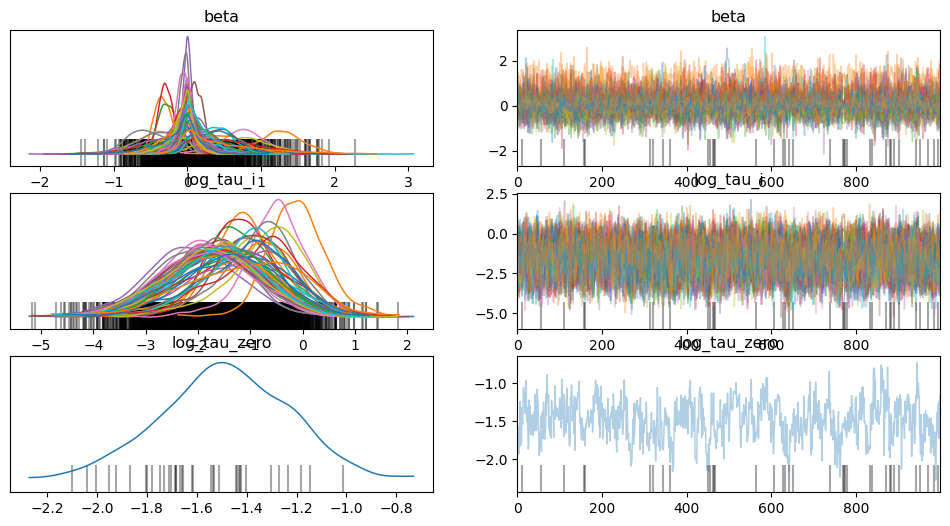

In [ ]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

## **3. Reparameterization**

We introduce a parameterization parameters $\lambda \in [0,1]$ for any variable $z$, and transform:

=> $z$ ~ $N (z | μ, σ)$

=> by defining  $z$ ~ $N(λμ, σ^λ)$

=> $z$ = $μ + σ^{1-λ}(z - λμ)$.

Thus, using the above transformation the joint density can be transformed as follows:
\begin{align}
p(\theta, \hat{\mu}, \mathbf{y}) & =\mathcal{N}(\theta \mid 0,1) \times
\mathcal{N}\left(\mu \mid \theta, \sigma_\mu\right) \times \mathcal{N}(\mathbf{y} \mid \mu, \sigma)
\end{align}

\begin{align}
p(\theta, \hat{\mu}, \mathbf{y}) & =\mathcal{N}(\theta \mid 0,1) \times \mathcal{N}\left(\hat{\mu} \mid \lambda \theta, \sigma_\mu^\lambda\right) \times \mathcal{N}\left(\mathbf{y} \mid \theta+\sigma_\mu^{1-\lambda}(\hat{\mu}-\lambda \theta), \sigma\right)
\end{align}


In [ ]:
def german_credit_reparam(beta_centeredness=None):
    def model():
        log_tau_zero = numpyro.sample("log_tau_zero", dist.Normal(0, 10))
        log_tau_i = numpyro.sample(
            "log_tau_i", dist.Normal(log_tau_zero, jnp.ones(num_features))
        )
        with numpyro.handlers.reparam(
            config={"beta": LocScaleReparam(beta_centeredness)}
        ):
            beta = numpyro.sample(
                "beta", dist.Normal(jnp.zeros(num_features), jnp.exp(log_tau_i))
            )
        numpyro.sample(
            "obs",
            dist.Bernoulli(logits=jnp.einsum("nd,md->mn", all_x, beta[jnp.newaxis, :])),
            obs=y,
        )

    return model

Now, using SVI we optimize $\lambda$.

In [ ]:
model = german_credit_reparam()
guide = AutoDiagonalNormal(model)
svi = SVI(model, guide, numpyro.optim.Adam(3e-4), Trace_ELBO(10))
svi_results = svi.run(rng_key, 10000)

100%|██████████| 10000/10000 [00:16<00:00, 588.87it/s, init loss: 2165.2424, avg. loss [9501-10000]: 576.7846]


In [ ]:
reparam_model = german_credit_reparam(
    beta_centeredness=svi_results.params["beta_centered"]
)

In [ ]:
nuts_kernel = NUTS(reparam_model)
mcmc_reparam = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000)
mcmc_reparam.run(rng_key, extra_fields=("num_steps",))

sample: 100%|██████████| 2000/2000 [00:07<00:00, 285.41it/s, 31 steps of size 1.28e-01. acc. prob=0.89]


In [ ]:
mcmc_reparam.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta_decentered[0]      0.12      0.40      0.06     -0.48      0.80    338.70      1.00
 beta_decentered[1]     -0.45      0.15     -0.45     -0.70     -0.21    791.23      1.00
 beta_decentered[2]     -0.38      0.17     -0.38     -0.65     -0.09    691.79      1.00
 beta_decentered[3]     -0.41      0.13     -0.41     -0.61     -0.19   1022.79      1.00
 beta_decentered[4]     -0.01      0.11     -0.01     -0.18      0.20   1176.84      1.00
 beta_decentered[5]      0.19      0.14      0.19     -0.04      0.41   1194.41      1.00
 beta_decentered[6]     -0.13      0.14     -0.13     -0.36      0.09   1227.24      1.00
 beta_decentered[7]     -0.07      0.12     -0.06     -0.24      0.14   1096.31      1.00
 beta_decentered[8]     -0.46      0.34     -0.46     -0.99      0.08    330.30      1.00
 beta_decentered[9]     -0.03      0.32     -0.02     -0.57      0.49    310.35      1.00
beta_dece

The number of divergences have significantly reduced from 37 to 1.

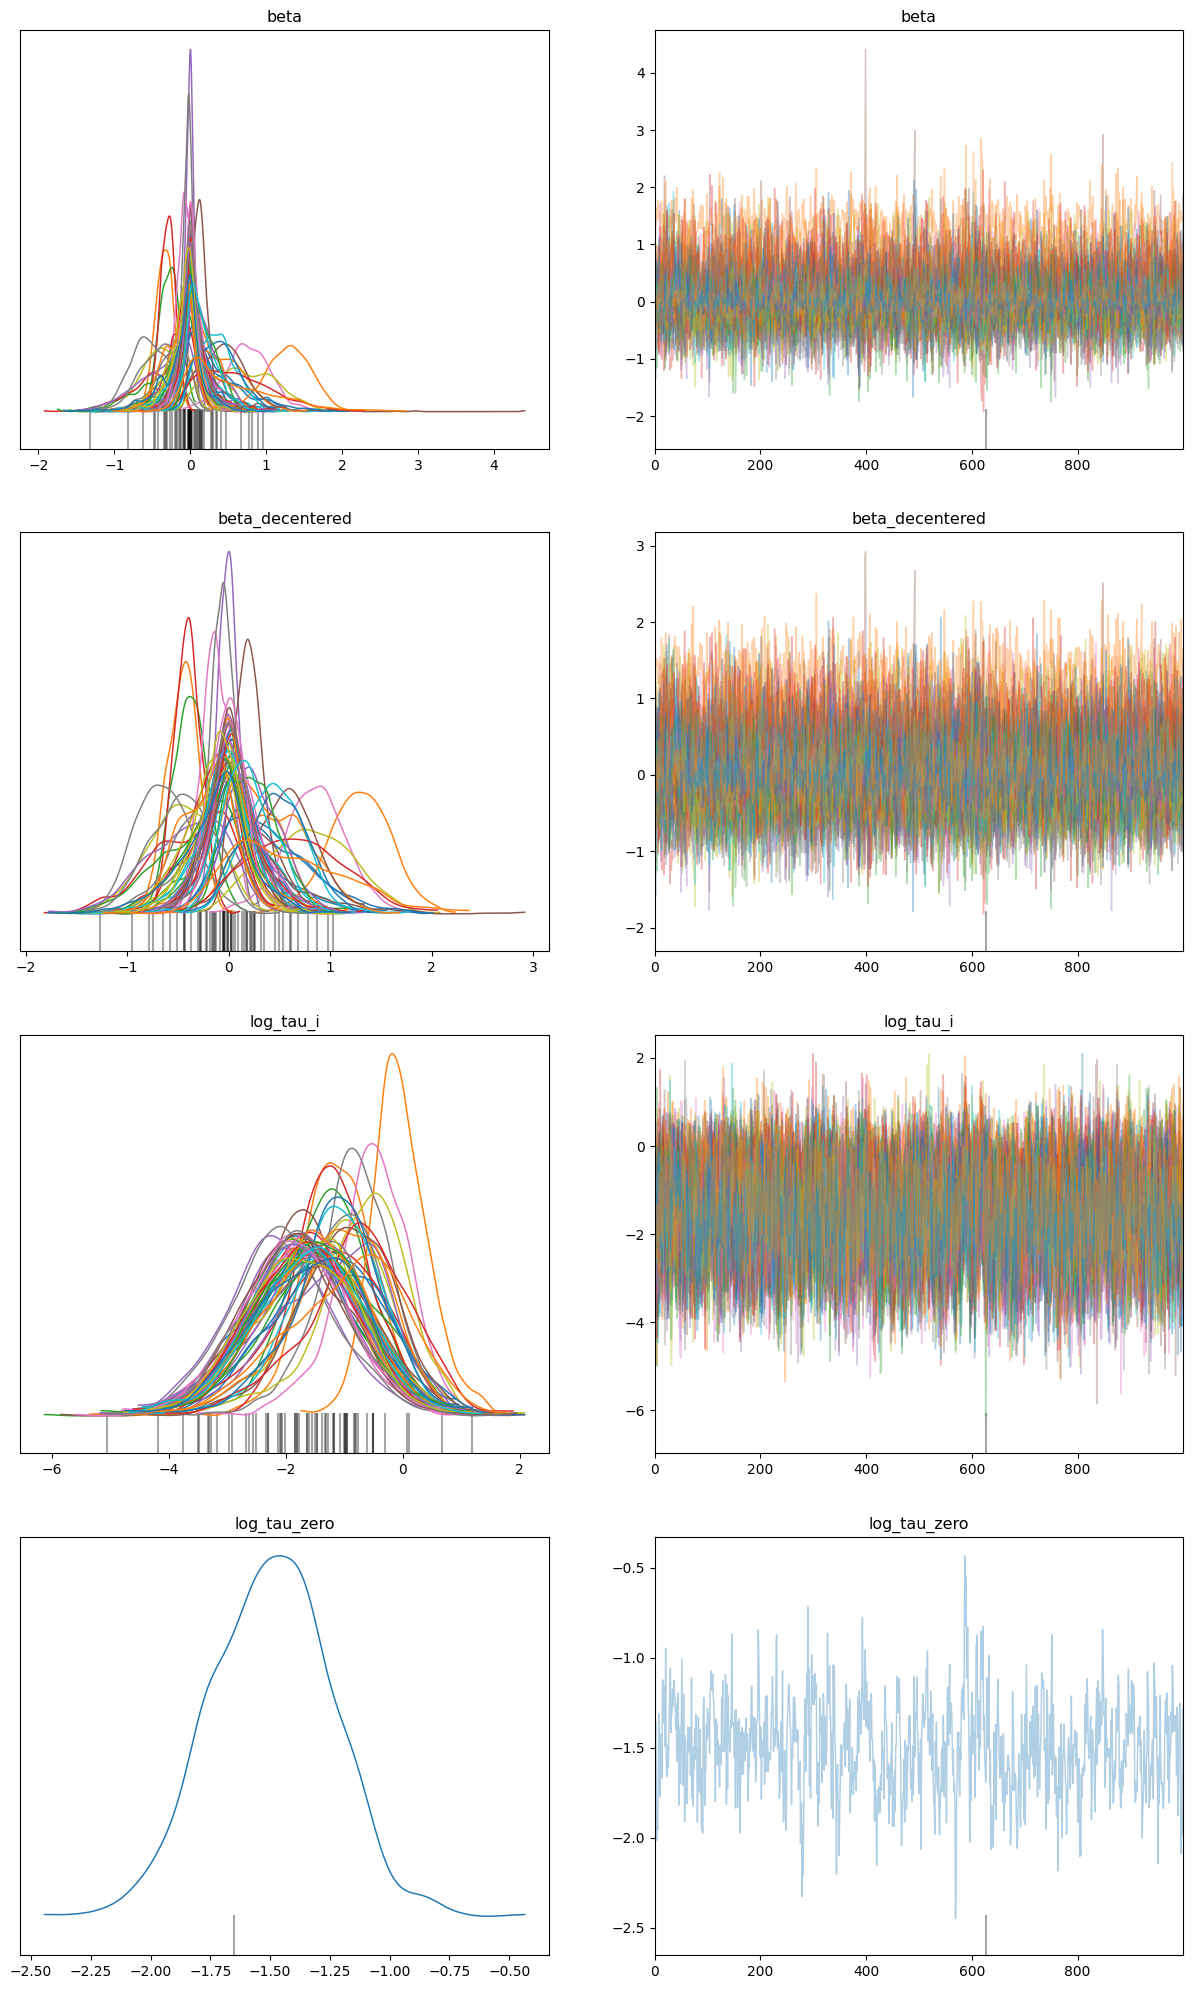

In [ ]:
data = az.from_numpyro(mcmc_reparam)
az.plot_trace(data, compact=True, figsize=(15, 25));

## **4. References:**
1. https://arxiv.org/abs/1906.03028
2. https://github.com/mgorinova/autoreparam/tree/master
